# Finetune with OpenAI

## Load data

In [25]:
import pandas as pd

# Cargar el CSV
# data = pd.read_csv('data/data_male.csv')
data = pd.read_csv('data/data_male.csv')
print(len(data))

# Eliminar filas con valores nulos solo en la columna 'text'
data = data.dropna(subset=['text'])
print(len(data))

# data = data[~data['EmoClass'].isin(['X', 'O'])]

data.head()

19842
19837


,FileName,text,EmoClass,EmoAct,EmoVal,EmoDom,SpkrID,Gender,Split_Set,PodcastID,StratifyCol,NewPartition,PseudoEmo,InvEntropyNorm,PseudoEmoNum
0,MSP-PODCAST_0288_0019,"mr. [excess 00:01:24] also known as ike, bbc r...",H,5.333333,5.416667,4.750000,123,Male,Train,288,0288_123_H,Train,H,1.000000,1
1,MSP-PODCAST_3371_0004_0001,... i decided to take a trip to canada with my...,N,3.400000,4.800000,4.200000,1769,Male,Development,3371,3371_1769_N,Evaluation,N,1.000000,0
2,MSP-PODCAST_0153_0436,"just clowning in the studio, people.",H,5.777778,5.111111,5.444444,15,Male,Train,153,0153_15_H,Evaluation,H,1.000000,1
3,MSP-PODCAST_2979_0216,social distancing implies that we're being dis...,X,3.200000,4.000000,3.600000,1565,Male,Train,2979,2979_1565_X,Evaluation,N,0.246159,0
4,MSP-PODCAST_0917_0196,... in 2016. we won. okay. and our core messag...,N,4.800000,3.600000,4.800000,266,Male,Train,917,0917_266_N,Train,N,1.000000,0


In [27]:
# Filtrar los datos en tres conjuntos basados en la columna 'Split_Set'
train_df = data.loc[data['NewPartition'] == 'Train']
dev_df = data.loc[data['NewPartition'] == 'Evaluation']
test_df = data.loc[data['NewPartition'] == 'Test']

# Verifica las primeras filas de cada conjunto
print("Conjunto Train:")
print(train_df.head())

print("Conjunto Development:")
print(dev_df.head())

print("Conjunto Test:")
print(test_df.head())

Conjunto Train:
                FileName                                               text  \
0  MSP-PODCAST_0288_0019  mr. [excess 00:01:24] also known as ike, bbc r...   
4  MSP-PODCAST_0917_0196  ... in 2016. we won. okay. and our core messag...   
5  MSP-PODCAST_0040_0223   all those decent men and women around the wor...   
7  MSP-PODCAST_1702_0156  yeah. it's like they're in some sort of geomet...   
8  MSP-PODCAST_5495_0498  that's a very good point of view. i love that....   

  EmoClass    EmoAct    EmoVal    EmoDom  SpkrID Gender    Split_Set  \
0        H  5.333333  5.416667  4.750000     123   Male        Train   
4        N  4.800000  3.600000  4.800000     266   Male        Train   
5        N  2.750000  3.666667  3.666667     425   Male        Train   
7        N  5.000000  4.200000  5.600000     981   Male  Development   
8        H  4.800000  5.400000  4.800000    2865   Male        Train   

   PodcastID  StratifyCol NewPartition PseudoEmo  InvEntropyNorm  PseudoEmoN

In [28]:
# Verificar las etiquetas únicas en EmoClass antes de mapear
print("Etiquetas únicas en 'EmoClass' antes del mapeo:")
print(dev_df['PseudoEmo'].unique())

Etiquetas únicas en 'EmoClass' antes del mapeo:
['N' 'H' 'A' 'F' 'C' 'S' 'U' 'D']


In [29]:
# Establecer la semilla para garantizar reproducibilidad
seed = 42

# Número de ejemplos por clase
n_ejemplos_por_clase = 50

# Seleccionar aleatoriamente ejemplos balanceados por clase para el conjunto de entrenamiento
train_df = train_df.groupby("PseudoEmo", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), n_ejemplos_por_clase), random_state=seed)
)

# Seleccionar aleatoriamente ejemplos balanceados por clase para el conjunto de desarrollo
dev_df = dev_df.groupby("PseudoEmo", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), n_ejemplos_por_clase // 2), random_state=seed)
)

/tmp/ipykernel_1903152/3428392459.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby("PseudoEmo", group_keys=False).apply(
/tmp/ipykernel_1903152/3428392459.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dev_df = dev_df.groupby("PseudoEmo", group_keys=False).apply(


## Prepare data

In [ ]:
# Definir el mensaje del sistema
system_message = {
    "role": "system",
    "content": "You are an assistant that classifies emotions based on transcripts."
}

# Crear una lista de mensajes formateados
formatted_data = []
for _, row in train_df.iterrows():
    messages = [
        system_message,
        {"role": "user", "content": row["text"]},
        {"role": "assistant", "content": row["PseudoEmo"]}
    ]
    formatted_data.append({"messages": messages})

# Guardar como archivo JSONL
import json
with open("data/fine_tune_train_male.jsonl", "w", encoding="utf-8") as f:
    for item in formatted_data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

In [31]:
# Definir el mensaje del sistema
system_message = {
    "role": "system",
    "content": "You are an assistant that classifies emotions based on transcripts."
}

# Crear una lista de mensajes formateados
formatted_data = []
for _, row in dev_df.iterrows():
    messages = [
        system_message,
        {"role": "user", "content": row["text"]},
        {"role": "assistant", "content": row["PseudoEmo"]}
    ]
    formatted_data.append({"messages": messages})

# Guardar como archivo JSONL
import json
with open("data/fine_tune_dev_male.jsonl", "w", encoding="utf-8") as f:
    for item in formatted_data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

## Load data to OpenAI

In [32]:
import configparser
import openai

config = configparser.ConfigParser()
config.read('config.ini')

OPENAI_MODEL = config['DEFAULT']['OPENAI_MODEL']
openai.api_key = config['DEFAULT']['OPENAI_API_KEY']

In [33]:
openai.files.create(
    file=open("data/fine_tune_train_male.jsonl", "rb"),
    purpose="fine-tune"
)

FileObject(id='file-K9HoCa3LGTjemTuDSvBBd8', bytes=110032, created_at=1737372342, filename='fine_tune_train_male.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [34]:
openai.files.create(
    file=open("data/fine_tune_dev_male.jsonl", "rb"),
    purpose="fine-tune"
)

FileObject(id='file-VnhuZm93yhogqheemjda4h', bytes=55375, created_at=1737372352, filename='fine_tune_dev_male.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

## Finetuning

In [35]:
openai.fine_tuning.jobs.create(
    training_file="file-K9HoCa3LGTjemTuDSvBBd8",
    validation_file="file-VnhuZm93yhogqheemjda4h",
    model="gpt-4o-2024-08-06"
)

FineTuningJob(id='ftjob-DFOhs5QRmiihezvExooVrfaf', created_at=1737372377, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs='auto'), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id='org-6n6bq55SqOv94y3EbtfwLuNX', result_files=[], seed=328645151, status='validating_files', trained_tokens=None, training_file='file-K9HoCa3LGTjemTuDSvBBd8', validation_file='file-VnhuZm93yhogqheemjda4h', estimated_finish=None, integrations=[], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs='auto')), type='supervised'), user_provided_suffix=None)

In [52]:
# Retrieve the state of a fine-tune
job = openai.fine_tuning.jobs.retrieve("ftjob-DFOhs5QRmiihezvExooVrfaf")

In [53]:
job

FineTuningJob(id='ftjob-DFOhs5QRmiihezvExooVrfaf', created_at=1737372377, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-2024-08-06:personal::Arkn2ZcA', finished_at=1737374606, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=2.0, n_epochs=3), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id='org-6n6bq55SqOv94y3EbtfwLuNX', result_files=['file-KVMTf3hcUzKS1nAhcSV1D7'], seed=328645151, status='succeeded', trained_tokens=55428, training_file='file-K9HoCa3LGTjemTuDSvBBd8', validation_file='file-VnhuZm93yhogqheemjda4h', estimated_finish=None, integrations=[], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=2.0, n_epochs=3)), type='supervised'), user_provided_suffix=None)

In [ ]:
# List 10 fine-tuning jobs
openai.fine_tuning.jobs.list(limit=10)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-DFOhs5QRmiihezvExooVrfaf', created_at=1737372377, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs='auto'), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id='org-6n6bq55SqOv94y3EbtfwLuNX', result_files=[], seed=328645151, status='validating_files', trained_tokens=None, training_file='file-K9HoCa3LGTjemTuDSvBBd8', validation_file='file-VnhuZm93yhogqheemjda4h', estimated_finish=None, integrations=[], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs='auto')), type='supervised'), user_provided_suffix=None), FineTuningJob(id='ftjob-IrG9bETvL2xsNmyBygK7yT8l', created_at=1737371829, error=Error(code='invalid_training_file', message='The job failed due to an invalid traini

## Output file

In [ ]:
openai.files.retrieve("file-KVMTf3hcUzKS1nAhcSV1D7")

## Use finetune model

In [ ]:
completion = openai.chat.completions.create(
    model="ft:gpt-4o-2024-08-06:personal::Arkn2ZcA",
    messages=[
        {"role": "system", "content": "You are an assistant that classifies emotions based on transcripts."},
        {"role": "user", "content": "Hello!"}
    ]
)

print(completion.choices[0].message)

In [59]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm

# Lista para almacenar las predicciones
predictions = []

# Loop de predicción
for idx, row in tqdm(dev_df.iterrows(), total=len(dev_df), desc="Processing predictions"):
    transcript = row['text']
    try:
        completion = openai.beta.chat.completions.parse(
            model="ft:gpt-4o-2024-08-06:personal::Arkn2ZcA",
            messages=[
                {
                    "role": "system", 
                    "content": "You are an assistant that classifies emotions based on transcripts."
                },
                {
                    "role": "user", 
                    "content": f"Classify this transcript into one of the following emotions: Angry (A), Sad (S), Happy (H), Surprise (U), Fear (F), Disgust (D), Contempt (C), Neutral (N). Transcript: {transcript}. Output only the letter that corresponds to the emotion."
                }
            ]
        )
        # Extraer la respuesta
        response_message = completion.choices[0].message.content
        emotion = response_message.strip()
        predictions.append(emotion)
        # print(f"Predicción en el índice {idx}: {emotion}")
    except Exception as e:
        print(f"Error en el índice {idx}: {e}")
        predictions.append(None)  # Manejo de errores: insertar None en caso de fallo

# Add predictions to the DataFrame
dev_df['predicted_emotion'] = predictions

Processing predictions: 100%|██████████| 200/200 [01:50<00:00,  1.80it/s]


ValueError: Length of values (200) does not match length of index (400)

In [61]:
def compute_metrics(true_labels, predicted_labels):

    # Obtener reporte completo
    report = classification_report(true_labels, predicted_labels, output_dict=True)
    
    # Obtener la matriz de confusión
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    # Extraer métricas para cada clase y globales
    metrics = {
        'accuracy': report['accuracy'],
        'weighted_f1': report['weighted avg']['f1-score'],
        'macro_f1': report['macro avg']['f1-score'],
        # 'weighted_precision': report['weighted avg']['precision'],
        # 'weighted_recall': report['weighted avg']['recall'],
        # La matriz de confusión no se incluye normalmente como una métrica devuelta porque no es un escalar
        'confusion_matrix': conf_matrix.tolist()  # Convertir a lista para asegurarse de que es serializable si es necesario
    }
    
    # # Añadir métricas específicas por clase si se requiere
    # for label, scores in report.items():
    #     if label not in ["accuracy", "macro avg", "weighted avg"]:
    #         metrics[f'{label}_precision'] = scores['precision']
    #         metrics[f'{label}_recall'] = scores['recall']
    #         metrics[f'{label}_f1'] = scores['f1-score']
    #         metrics[f'{label}_support'] = scores['support']
    
    return metrics

In [62]:
true_labels = dev_df['PseudoEmo']
predicted_labels = dev_df['predicted_emotion']
print(len(true_labels))
print(len(predicted_labels))

metrics = compute_metrics(true_labels, predicted_labels)
metrics

200
200


{'accuracy': 0.295,
 'weighted_f1': 0.25983788676761027,
 'macro_f1': 0.25983788676761027,
 'confusion_matrix': [[2, 13, 5, 1, 0, 0, 3, 1],
  [0, 15, 3, 2, 0, 4, 0, 1],
  [0, 8, 11, 1, 0, 1, 4, 0],
  [2, 7, 2, 2, 0, 10, 1, 1],
  [0, 5, 0, 1, 5, 11, 2, 1],
  [1, 6, 3, 0, 0, 13, 2, 0],
  [0, 5, 4, 1, 0, 4, 11, 0],
  [0, 9, 3, 2, 0, 10, 1, 0]]}

In [57]:
num_labels = 8
id2label = dict(zip(train_df["PseudoEmoNum"], train_df["PseudoEmo"]))
label2id = dict(zip(train_df["PseudoEmo"], train_df["PseudoEmoNum"]))

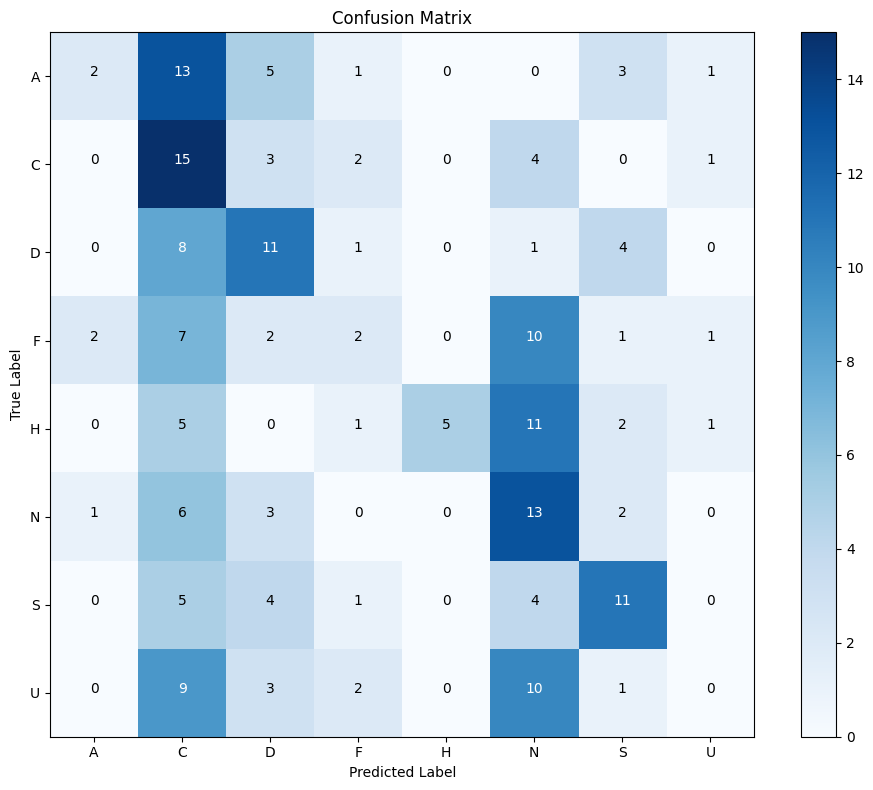

In [63]:
import matplotlib.pyplot as plt
import numpy as np

labels = label2id.keys()
conf_matrix = metrics['confusion_matrix']

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Agregar etiquetas
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# Rótulos de valores dentro de cada celda
conf_matrix = np.array(conf_matrix)

# Calcular el umbral
thresh = conf_matrix.max() / 2
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(
        j, i, format(conf_matrix[i, j], 'd'),
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black"
    )

# Etiquetas de los ejes
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()